## Minneapolis interstate traffic prediction

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [217]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

## Dataset Description

#### This dataset includes weather conditions, temperature, date and time, special holidays and traffic volume information.
#### Based on this information, I will use linear regression and a few other models to predict the traffic volume.
#### In the second part, I will use the same data for classifying high or low traffic volume using logistic regression.

In [218]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [219]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


##### As we see there are no null values in the dataset

In [221]:
df.shape

(48204, 9)

In [222]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
New Years Day                    6
Martin Luther King Jr Day        6
Christmas Day                    6
State Fair                       5
Columbus Day                     5
Memorial Day                     5
Washingtons Birthday             5
Independence Day                 5
Veterans Day                     5
Name: holiday, dtype: int64

The frequency of values in holiday column is not balanced at all, most of the days are "None" or normal days. <br>
Lets explore other categorical columns in general:

In [223]:
df.drop('date_time', axis=1).describe(include='object')

,holiday,weather_main,weather_description
count,48204,48204,48204
unique,12,11,38
top,None,Clouds,sky is clear
freq,48143,15164,11665


#### Visualizing different features can help to choose and/or alter the best ones for the prediction:

temprature distribution plot:

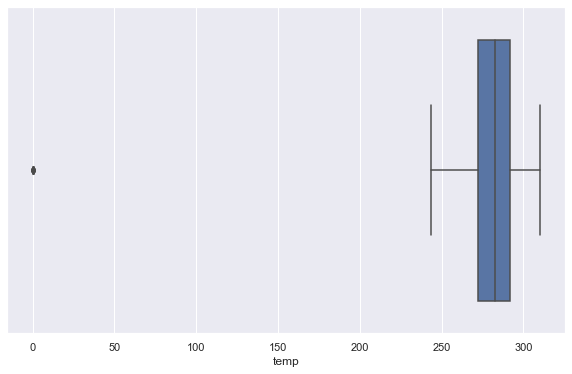

In [224]:
plt.figure(figsize=(10,6))
sns.boxplot('temp', data = df)
plt.show()

There is a wrong data point (0 kelvin degree) 

In [225]:
df['rain_1h'].value_counts()

0.00     44737
0.25       948
0.51       256
1.02       123
0.30       121
         ...  
5.11         1
3.01         1
2.73         1
18.03        1
2.11         1
Name: rain_1h, Length: 372, dtype: int64

Most of the rain data (mm per hour) is equal to zero, so for plotting it is better to choose a smaller range:

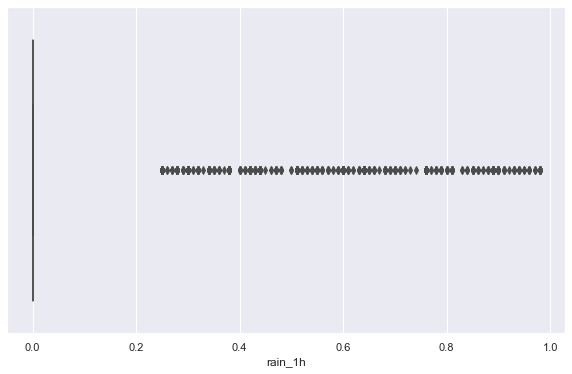

In [226]:
plt.figure(figsize=(10,6))
sns.boxplot(df.rain_1h.loc[df.rain_1h<1], data = df)
plt.show()

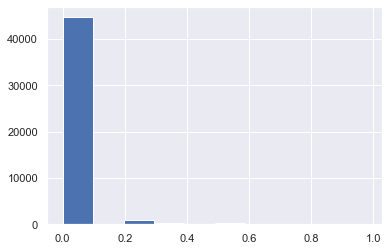

In [227]:
plt.hist(df.rain_1h.loc[df.rain_1h<1])
plt.show()

The same thing is true for snow data:

In [228]:
df['snow_1h'].value_counts()

0.00    48141
0.05       14
0.06       12
0.10        6
0.13        6
0.51        6
0.25        6
0.32        5
0.17        3
0.08        2
0.44        2
0.21        1
Name: snow_1h, dtype: int64

Clouds all show the percentage of cloud coverage in that specific time:

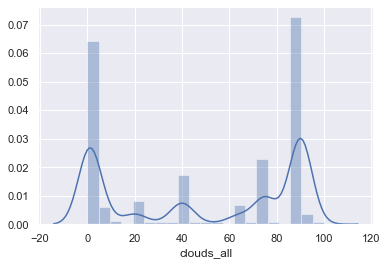

In [229]:
sns.distplot(df.clouds_all)
plt.show()

The main weather groups plot:

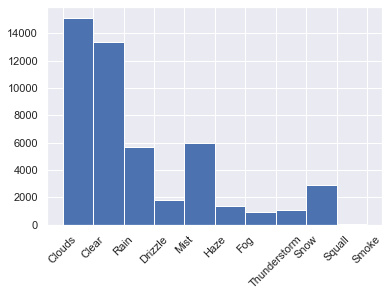

In [230]:
plt.hist(df['weather_main'])
plt.xticks(rotation=45)
plt.show()

Weather descriptions plot:


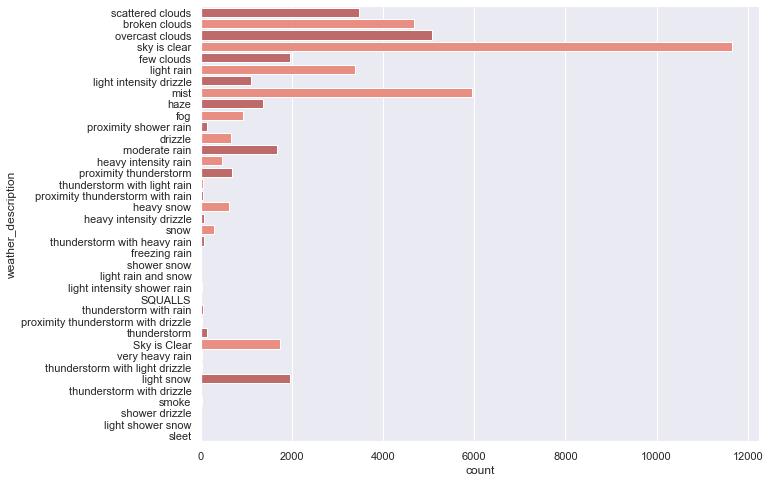

In [231]:
plt.figure(figsize=(10,8))
sns.countplot(y='weather_description', data=df, palette= ["#CD5C5C", "#FA8072"])
plt.show()

## Feature engineering

In [232]:
transform_df = df.copy()

Eliminating the temperature outlier:

In [233]:
transform_df = transform_df.loc[transform_df.temp>-250]

In [234]:
transform_df['date_time'] = pd.to_datetime(transform_df['date_time'])

Transforming the date_time column into separate numerical columns for year, month and day:

In [235]:
transform_df['year'] = transform_df['date_time'].dt.year
transform_df['month'] = transform_df['date_time'].dt.month
transform_df['day'] = transform_df['date_time'].dt.day
transform_df['hour'] = transform_df['date_time'].dt.hour
transform_df = transform_df.drop('date_time', axis=1)

In [236]:
transform_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,year,month,day,hour
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2012,10,2,9
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2012,10,2,10
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2012,10,2,11
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2012,10,2,12
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2012,10,2,13


Let's check the relation between the numerical values and traffic volume:

In [237]:
numerical_df = transform_df.select_dtypes(include=['int64', 'float'])
numerical_df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,year,month,day,hour
0,288.28,0.0,0.0,40,5545,2012,10,2,9
1,289.36,0.0,0.0,75,4516,2012,10,2,10
2,289.58,0.0,0.0,90,4767,2012,10,2,11
3,290.13,0.0,0.0,90,5026,2012,10,2,12
4,291.14,0.0,0.0,75,4918,2012,10,2,13


In [238]:
abs_corr_coeffs = numerical_df.corr()['traffic_volume'].abs().sort_values()
abs_corr_coeffs

snow_1h           0.000733
month             0.002533
rain_1h           0.004714
year              0.004753
day               0.007587
clouds_all        0.067054
temp              0.130299
hour              0.352401
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

As we see there are not strong correlations here.

The special days (holidays) are very few in comparison to the normal days, so we can change that column to a boolean column which indicates if the day is a special day or a normal day:

In [239]:
def is_holiday(day):
    if day == 'None':
        return False
    else:
        return True
transform_df['holiday'] = transform_df['holiday'].map(is_holiday)

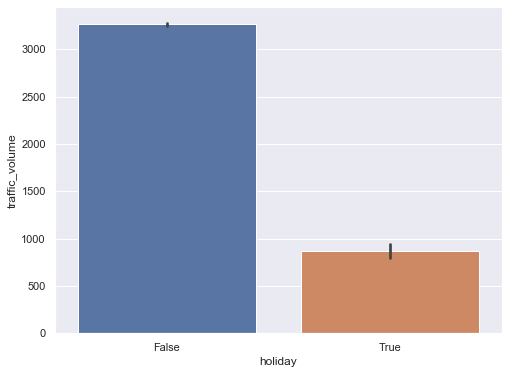

In [240]:
plt.figure(figsize=(8,6))
sns.barplot(x='holiday', y='traffic_volume', data = transform_df)
plt.show()

Encoding the categorical features:

In [241]:
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
    
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

In [242]:
transform_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,year,month,day,hour,...,weather_description_sleet,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with drizzle,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
0,False,288.28,0.0,0.0,40,5545,2012,10,2,9,...,0,0,0,0,0,0,0,0,0,0
1,False,289.36,0.0,0.0,75,4516,2012,10,2,10,...,0,0,0,0,0,0,0,0,0,0
2,False,289.58,0.0,0.0,90,4767,2012,10,2,11,...,0,0,0,0,0,0,0,0,0,0
3,False,290.13,0.0,0.0,90,5026,2012,10,2,12,...,0,0,0,0,0,0,0,0,0,0
4,False,291.14,0.0,0.0,75,4918,2012,10,2,13,...,0,0,0,0,0,0,0,0,0,0


## Features correlation with the target column

In [243]:
abs_corr_coeffs = transform_df.corr()['traffic_volume'].abs().sort_values()
abs_corr_coeffs

weather_main_Smoke                                         0.000227
weather_description_smoke                                  0.000227
snow_1h                                                    0.000733
weather_description_proximity thunderstorm with drizzle    0.001176
weather_description_shower drizzle                         0.001616
weather_description_heavy intensity drizzle                0.002042
month                                                      0.002533
weather_description_thunderstorm with rain                 0.003021
weather_main_Drizzle                                       0.003082
weather_description_thunderstorm with drizzle              0.003122
weather_description_freezing rain                          0.003418
weather_description_light rain and snow                    0.003939
weather_description_sleet                                  0.004181
weather_description_thunderstorm with light drizzle        0.004267
rain_1h                                         

Choosing the features with more correlation to the target column:

In [244]:
abs_corr_coeffs[abs_corr_coeffs > 0.04]

holiday                                 0.042897
weather_description_few clouds          0.044678
weather_description_mist                0.061734
weather_main_Mist                       0.061734
weather_main_Clear                      0.063652
weather_description_broken clouds       0.066126
clouds_all                              0.067054
weather_description_sky is clear        0.073441
weather_description_scattered clouds    0.086202
weather_main_Clouds                     0.122285
temp                                    0.130299
hour                                    0.352401
traffic_volume                          1.000000
Name: traffic_volume, dtype: float64

## Features correlation map and reduction

In [245]:
reduced_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.04].index, axis=1)

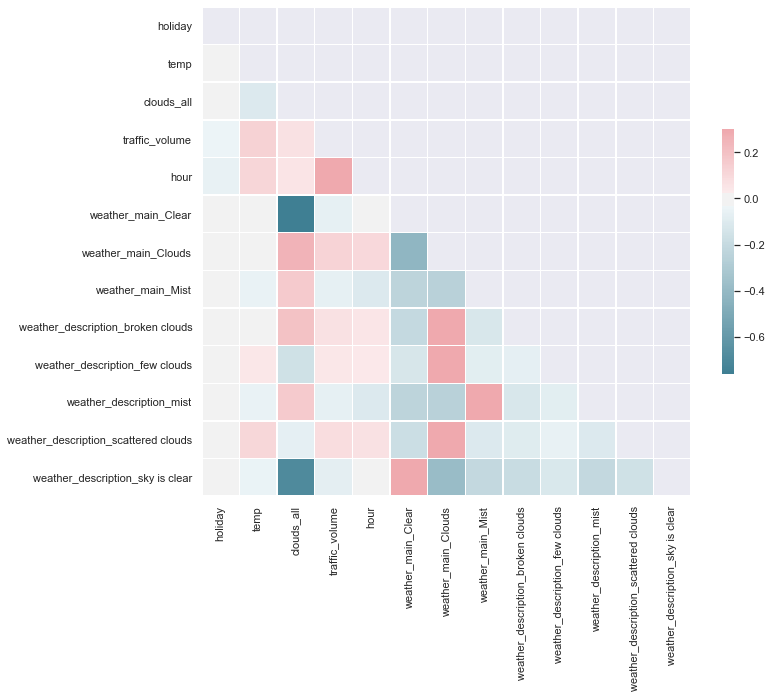

In [246]:
corr = reduced_df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the map, the features that are highly correlated can be reduced to just one that is more related to the target:

In [247]:
reduced_df = reduced_df.drop(['weather_description_mist', 'weather_description_few clouds', 
                              'weather_description_broken clouds', 'weather_description_scattered clouds', 
                              'weather_main_Clear'], axis=1)

In [248]:
reduced_df.head()

,holiday,temp,clouds_all,traffic_volume,hour,weather_main_Clouds,weather_main_Mist,weather_description_sky is clear
0,False,288.28,40,5545,9,1,0,0
1,False,289.36,75,4516,10,1,0,0
2,False,289.58,90,4767,11,1,0,0
3,False,290.13,90,5026,12,1,0,0
4,False,291.14,75,4918,13,1,0,0


## Data split

In [249]:
X = reduced_df.drop('traffic_volume', axis=1).values
y = reduced_df['traffic_volume'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = reduced_df.drop('traffic_volume', axis=1).columns

## Feature scaling

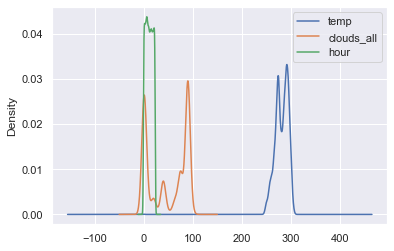

In [250]:
X_train_df[['temp', 'clouds_all', 'hour']].plot.kde()

In [251]:
minmax = MinMaxScaler()
X_train_data = minmax.fit_transform(X_train)
X_test_data = minmax.transform(X_test)

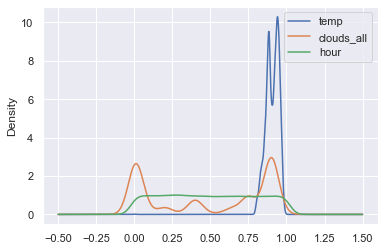

In [252]:
X_train_df = pd.DataFrame(X_train_data)
X_train_df.columns = reduced_df.drop('traffic_volume', axis=1).columns
X_train_df[['temp', 'clouds_all', 'hour']].plot.kde()

## Regression models

In [253]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train_data, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [254]:
y_pred = regressor.predict(X_test_data)

In [257]:
regressor.score(X_train_data, y_train)

0.1415931135325632

In [258]:
from sklearn.metrics import mean_squared_error

In [259]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(rmse, mse)

1836.7541009947413 3373665.6275210003


In [260]:
from sklearn.linear_model import Lasso
regressor = Lasso()
regressor.fit(X_train_data, y_train)
y_pred = regressor.predict(X_test_data)
regressor.score(X_test_data, y_test)

0.1427633970297857

The model is not learning from the data and applying Lasso did not change the result.
Now trying Polynomial:

In [263]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_train_data)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)
X_poly_test = poly_reg.transform(X_test_data)

y_pred = lin_reg_2.predict(X_poly_test)
lin_reg_2.score(X_poly_test, y_test)

0.6923543410720707

In [264]:
lin_reg_2.score(X_poly, y_train)

0.6850163761075827

The score improved with this model. Now again trying Lasso:

In [273]:
from sklearn.linear_model import Lasso
regressor = Lasso(max_iter=10000)
regressor.fit(X_poly, y_train)
y_pred = regressor.predict(X_poly_test)
regressor.score(X_poly_test, y_test)

0.6706746271050421

In [271]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
print(RMSE)

1138.6988829010436


Trying Huber regressor for robust regression:

In [275]:
from sklearn.linear_model import HuberRegressor
regressor = HuberRegressor(max_iter=1000)
regressor.fit(X_poly, y_train)
y_pred = regressor.predict(X_poly_test)
regressor.score(X_poly_test, y_test)

C:\Users\Hoda\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.6756921927509147

### Changing the target value, traffic volume, to a categorical column for the classification task:

First, different classes should be identified:

In [304]:
traffic_volume_categorical = {
    'no_traffic': {
        'min': float('-inf'),
        'max': np.quantile(y_train, 0.2),
        'class': 0
    },
    'light_traffic': {
        'min': np.quantile(y_train, 0.2),
        'max': np.quantile(y_train, 0.4),
        'class': 1
    },
    'normal_traffic': {
        'min': np.quantile(y_train, 0.4),
        'max': np.quantile(y_train, 0.6),
        'class': 2
    },
    'heavy_traffic': {
        'min': np.quantile(y_train, 0.6),
        'max': np.quantile(y_train, 0.8),
        'class': 3
    },
    'super_heavy_traffic': {
        'min': np.quantile(y_train, 0.8),
        'max': float('inf'),
        'class': 4
    },
}

The target value in train and test data should be changed accordingly:

In [310]:
categorical_y_train = []
categorical_y_test = []
for i in y_train:
    for _, category in traffic_volume_categorical.items():
        if i >= category['min'] and i < category['max']:
            categorical_y_train.append(category['class'])
            break

for i in y_test:
    for _, category in traffic_volume_categorical.items():
        if i >= category['min'] and i < category['max']:
            categorical_y_test.append(category['class'])
            break

Now trying logistic regression:

In [318]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(X_train_data, categorical_y_train)

C:\Users\Hoda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [319]:
clf.score(X_test_data, categorical_y_test)

0.47236743838685585

In [333]:
clf = LogisticRegression().fit(X_poly, categorical_y_train)
clf.score(X_poly_test, categorical_y_test)

C:\Users\Hoda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6053024645257655

Using the polynomial features improved the results.